In [24]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import time
from sklearn.model_selection import GridSearchCV

import ast


In [4]:
full_data = pd.read_csv("/Users/blessing/Desktop/Thesis dump/data analysis and modelling/vilnius-apartment-price-prediction/EDA/full_data.csv")

In [5]:
overall_medians = {
    'TOTAL_CHILDREN': full_data['TOTAL_CHILDREN'].median(),
    'TOTAL_PEOPLE': full_data['TOTAL_PEOPLE'].median(),
    'TOTAL_DIVORCED': full_data['TOTAL_DIVORCED'].median(),
    'TOTAL_SINGLE': full_data['TOTAL_SINGLE'].median(),
    'TOTAL_WIDOWED': full_data['TOTAL_WIDOWED'].median(),
    'TOTAL_MARRIED': full_data['TOTAL_MARRIED'].median(),
    'AVG_BIRTH_YEAR': full_data['AVG_BIRTH_YEAR'].median()
}

def fill_missing(row, feature, neighborhood_medians, overall_median):
    """
    Fills missing values based on neighborhood median, or overall median if neighborhood is not in the list.
    """
    if pd.isna(row[feature]):
        return neighborhood_medians.get(row['neighbourhood'], overall_median)
    

    return row[feature]

for feature, overall_median in overall_medians.items():
    neighborhood_medians = full_data.groupby('neighbourhood')[feature].median().to_dict()
    full_data[feature] = full_data.apply(
        lambda row: overall_median if pd.isna(row['neighbourhood']) else fill_missing(row, feature, neighborhood_medians, overall_median),
        axis=1 
    )

    full_data[feature].fillna(overall_median,inplace=True)

    

# Check for remaining missing values
missing_summary = full_data.isna().sum()
print("Missing values after filling:")
print(missing_summary[missing_summary > 0])


Missing values after filling:
Building Energy Efficiency Class    2319
Additional premises                 1012
Additional Equipment                1024
Security                             987
Public transport stop                  8
Percent_Decrease                    2178
STREET                               715
dtype: int64


In [6]:
mean_per_neighborhood = full_data.groupby('neighbourhood')['Nearest kindergarten'].mean()

# Step 2: Fill missing values based on the mean per neighborhood
def fill_missing(row):
    if pd.isna(row['Nearest kindergarten']):
        return mean_per_neighborhood[row['neighbourhood']]
    else:
        return row['Nearest kindergarten']

full_data['Nearest kindergarten'] = full_data.apply(fill_missing, axis=1)
mean_per_neighborhood = full_data.groupby('street')['Nearest educational institution'].mean()

# Step 2: Fill missing values based on the mean per neighborhood
def fill_missing(row):
    if pd.isna(row['Nearest educational institution']):
        return mean_per_neighborhood[row['street']]
    else:
        return row['Nearest educational institution']

full_data['Nearest educational institution'] = full_data.apply(fill_missing, axis=1)

mean_per_neighborhood = full_data.groupby('neighbourhood')['Public transport stop'].mean()

# Step 2: Fill missing values based on the mean per neighborhood
def fill_missing(row):
    if pd.isna(row['Public transport stop']):
        return mean_per_neighborhood[row['neighbourhood']]
    else:
        return row['Public transport stop']

full_data['Public transport stop'] = full_data.apply(fill_missing, axis=1)

mean_per_neighborhood = full_data.groupby('neighbourhood')['Public transport stop'].mean()

# Step 2: Fill missing values based on the mean per neighborhood
def fill_missing(row):
    if pd.isna(row['Public transport stop']):
        return mean_per_neighborhood[row['neighbourhood']]
    else:
        return row['Public transport stop']

full_data['Public transport stop'] = full_data.apply(fill_missing, axis=1)

In [9]:



# Assuming the current year is relevant for calculations
def calculate_current_year():
    return datetime.now().year

# Add current year
current_year = calculate_current_year()

# Engineering Features
full_data['building_age'] = current_year - full_data['build_year']
full_data['time_since_renovation'] = current_year - full_data['renovation_year']
full_data.loc[full_data['renovation_year'].isna(), 'time_since_renovation'] = current_year - full_data['build_year']

full_data['is_recently_renovated'] = full_data['time_since_renovation'] < 10

# Floor and Building Type
full_data['floor_ratio'] = full_data['Floor'] / full_data['No. of floors']
full_data['low_rise'] = full_data['No. of floors'] <= 3
full_data['mid_rise'] = (full_data['No. of floors'] > 3) & (full_data['No. of floors'] <= 9)
full_data['high_rise'] = full_data['No. of floors'] > 9

# Demographic Features
full_data['marriage_rate'] = full_data['TOTAL_MARRIED'] / full_data['TOTAL_PEOPLE']
full_data['children_ratio'] = full_data['TOTAL_CHILDREN'] / full_data['TOTAL_PEOPLE']
full_data['single_ratio'] = full_data['TOTAL_SINGLE'] / full_data['TOTAL_PEOPLE']
full_data['divorced_or_widowed_rate'] = (
    full_data['TOTAL_DIVORCED'] + full_data['TOTAL_WIDOWED']
) / full_data['TOTAL_PEOPLE']
full_data['avg_age'] = current_year - full_data['AVG_BIRTH_YEAR']

# Location Features
full_data['amenity_access_score'] = 1 / (
    full_data['Nearest kindergarten'] +
    full_data['Nearest educational institution'] +
    full_data['Nearest shop'] +
    full_data['Public transport stop']
)


# Neighborhood Dynamics

full_data['is_family_friendly'] = (full_data['children_ratio'] > 0.3).astype("int")
full_data['is_retirement_area'] = (full_data['avg_age'] > 60 ).astype("int")

full_data['floor_accessibility_impact'] = ((full_data['building_age'] > 50) & (full_data['Floor'] > 3)).astype("int")


full_data['transport_proximity_rank'] = full_data.groupby('neighbourhood')['Public transport stop'].rank(ascending=True)
full_data['neighborhood_age_diversity'] = full_data.groupby('neighbourhood')['avg_age'].transform('std')
full_data['neighborhood_renovation_ratio'] = full_data.groupby('neighbourhood')['is_recently_renovated'].transform('mean')



# Ratio of total children to the total number of families
full_data['children_to_family_ratio'] = full_data['TOTAL_CHILDREN'] / (
    full_data['TOTAL_MARRIED'] + full_data['TOTAL_DIVORCED'] + full_data['TOTAL_WIDOWED']
)

# Ratio of rooms to area (room density)
full_data['room_density'] = full_data['Number of rooms'] / full_data['Area']

full_data['apartment_size_ratio'] = full_data['Area'] / full_data.groupby('neighbourhood')['Area'].transform('mean')
full_data['apartment_age_ratio'] = full_data['building_age'] / full_data.groupby('neighbourhood')['building_age'].transform('mean')
full_data['floor_rank'] = full_data.groupby('neighbourhood')['Floor'].rank(method='dense')
full_data['rooms_per_floor'] = full_data['Number of rooms'] / full_data['Floor']
full_data['is_new_or_renovated'] = (full_data['building_age'] < 5) | (full_data['is_recently_renovated'])


# Public transport stop proximity categorization
full_data['is_close_to_transport'] = full_data['Public transport stop'] <= 500


# Preview the engineered features
print(full_data.head())


      city neighbourhood         street   Area  Number of rooms  Floor  \
0  Vilnius   Santariškės  Dangeručio g.  65.01                3      3   
1  Vilnius    Antakalnis  Antakalnio g.  83.30                3      1   
2  Vilnius   Lazdynėliai     Lietaus g.  30.65                1      4   
3  Vilnius       Bajorai    Bajorų kel.  43.05                2      3   
4  Vilnius   Lazdynėliai  Lazdynėlių g.  63.02                4      2   

   No. of floors Building type         Heating system           Equipment  \
0              4         Brick  Electric, aerothermal      Fully equipped   
1              3         Brick                Central  Partially equipped   
2              4         Brick     Central thermostat  Partially equipped   
3              5         Brick     Central thermostat  Partially equipped   
4              4         Brick     Central thermostat  Partially equipped   

   ... neighborhood_age_diversity neighborhood_renovation_ratio  \
0  ...                   

In [10]:
full_data['Additional premises'].fillna("empty",inplace=True)
full_data['Has_Balcony'] = full_data['Additional premises'].str.contains('Balcony').astype("int")
full_data['Has_Terrace'] = full_data['Additional premises'].str.contains('Terrace').astype("int")
full_data['Has_Parking_space'] = full_data['Additional premises'].str.contains('Parking space').astype("int")
full_data['Has_Sauna'] = full_data['Additional premises'].str.contains('Sauna').astype("int")
full_data['Has_Attic'] = full_data['Additional premises'].str.contains('Attic').astype("int")
full_data['Has_Storeroom'] = full_data['Additional premises'].str.contains('Storeroom').astype("int")
full_data['Has_Cellar'] = full_data['Additional premises'].str.contains('Cellar').astype("int")
full_data['Has_Closet'] = full_data['Additional premises'].str.contains('Closet').astype("int")

full_data['Is_first_floor'] = (full_data['Floor'] == 1).astype(int)

In [13]:

label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder(categories=[['Under construction','Other','Not equipped', 'Partially equipped', 'Fully equipped']])


In [14]:
data = full_data.copy()

In [15]:
data['neighbourhood'] = label_encoder.fit_transform(data['neighbourhood'])
data['street'] = label_encoder.fit_transform(data['street'])
data['Building type'] = label_encoder.fit_transform(data['Building type'])
data['Equipment'] = ordinal_encoder.fit_transform(data[['Equipment']])

In [16]:
data.reset_index(drop=True, inplace=True)

In [17]:
model_data = data.copy()

In [18]:
# Function to calculate the number of additional items starting with capital letters
def count_additional_items_capitalized(row):
    if row.strip().lower() == "empty" or row.strip() == "":  # Handle 'empty' or empty strings
        return 0
    # Split the string into words and count only those starting with a capital letter
    return sum(1 for word in row.split() if word.istitle())

# Create the new column for the number of additional items
model_data['No of Additional Equipments'] = model_data['Additional premises'].apply(count_additional_items_capitalized)


In [29]:
# Baseline model

In [30]:

def evaluate_model(model, X_train, X_test, y_train, y_test, log_transform=False):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(y_test_pred.shape)
    # Reverse log transformation if needed
    # if log_transform:
    #     y_train = np.expm1(y_train)
    #     y_test = np.expm1(y_test)
    #     y_train_pred = np.expm1(y_train_pred)
    #     y_test_pred = np.expm1(y_test_pred)
    
    metrics = {
        "Train_R2": r2_score(y_train, y_train_pred),
        "Test_R2": r2_score(y_test, y_test_pred),
        "Train_MAE": mean_absolute_error(y_train, y_train_pred),
        "Test_MAE": mean_absolute_error(y_test, y_test_pred),
        "Train_RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "Test_RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "Train_MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "Test_MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    }
    return   y_train_pred ,   y_test_pred, metrics


# Target variable
target = "Price"
X = model_data.drop(columns=[target])  # Remove target columns from predictors
y = model_data[target]
y_log = np.log1p(y)  # Log transform for linear models

# Define models
models = {
    "LinearRegression": LinearRegression()
}

# Predefined numeric features
numeric_features = [
    'Area', 'Number of rooms', 'Floor', 'No. of floors',
    'AVG_BIRTH_YEAR', 'TOTAL_CHILDREN', 'TOTAL_PEOPLE',
    'TOTAL_DIVORCED', 'TOTAL_WIDOWED', 'TOTAL_MARRIED',
    'TOTAL_SINGLE', 'build_year'
]

# Define variable groups
variable_groups = [
        
    model_data[['neighbourhood', 'street', 'Area', 'Number of rooms', 'Floor', 'build_year',
                'No. of floors', 'Building type', 'Equipment', 'No of Additional Equipments',
                'Nearest kindergarten', 'Nearest educational institution', 'Nearest shop',
                'Public transport stop']],
   
    
         
]

# Train and evaluate models
results = {}
for i, variables in enumerate(variable_groups):
    print(f"Evaluating Variable Group {i + 1}...")
    X_group = variables
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y, test_size=0.2, random_state=42)
    
    # Dynamic numeric features based on the current group
    valid_numeric_features = [feature for feature in numeric_features if feature in X_group.columns]
    
    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), valid_numeric_features)
        ],
        remainder='passthrough'  # Pass encoded categorical variables as is
    )
    
    # Scale data
    X_train_scaled = preprocessor.fit_transform(X_train_group)
    X_test_scaled = preprocessor.transform(X_test_group)
    
    for name, model in models.items():
        print(f"Training {name} on Variable Group {i + 1}...")
        # if name in ["Ridge", "Lasso", "ElasticNet", "LinearRegression"]:  # Use log target for linear models
        #     model.fit(X_train_scaled, y_train_log_group)
        #     metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_log_group, y_test_log_group, log_transform=True)
        # else:  # Use original target for non-linear models
        model.fit(X_train_scaled, y_train_group)
        y_train_pred ,   y_test_pred,metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_group, y_test_group, log_transform=False)
    
        # Save metrics
        results[f"Group {i + 1} - {name}"] = metrics


# Convert results to DataFrame
baseline_df = pd.DataFrame(results).T  # Transpose for better readability



Evaluating Variable Group 1...
Training LinearRegression on Variable Group 1...
(587,)


In [31]:
baseline_df

,Test_MAE,Test_MAPE,Test_R2,Test_RMSE,Train_MAE,Train_MAPE,Train_R2,Train_RMSE
Group 1 - LinearRegression,44436.009709,27.38242,0.595257,62963.725454,46797.145258,28.826883,0.51231,66596.140575


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


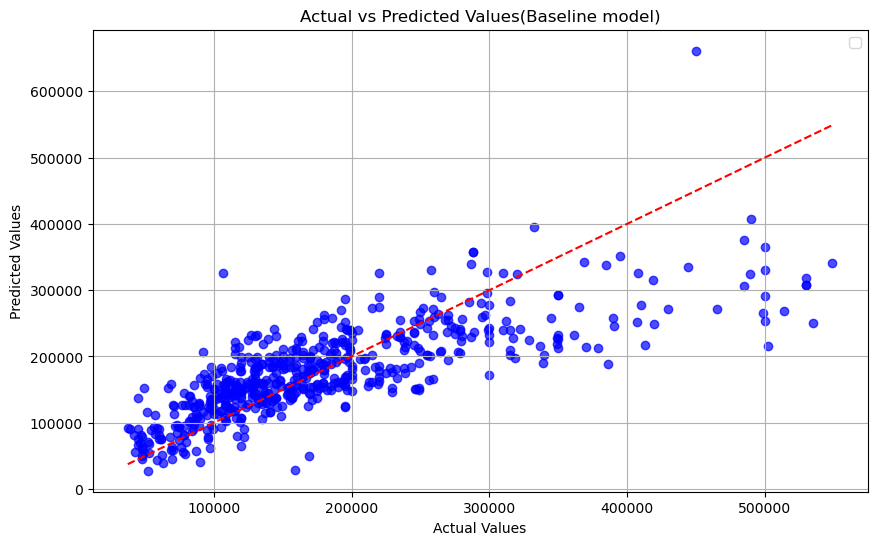

In [32]:
import matplotlib.pyplot as plt

# Example data (replace these with your actual values)
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(10, 6))

plt.scatter(y_test_group, y_test_pred, color='blue', alpha=0.7)

# Line for Perfect Predictions
min_val = min(y_test_group)
max_val = max(y_test_group)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Plot Styling
plt.title("Actual vs Predicted Values(Baseline model)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


In [35]:


# Define evaluate_model function with MAPE
# Define evaluate_model function with log reversal
def evaluate_model(model, X_train, X_test, y_train, y_test, log_transform=False):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(y_test_pred.shape)
    # Reverse log transformation if needed
    # if log_transform:
    #     y_train = np.expm1(y_train)
    #     y_test = np.expm1(y_test)
    #     y_train_pred = np.expm1(y_train_pred)
    #     y_test_pred = np.expm1(y_test_pred)
    
    metrics = {
        "Train_R2": r2_score(y_train, y_train_pred),
        "Test_R2": r2_score(y_test, y_test_pred),
        "Train_MAE": mean_absolute_error(y_train, y_train_pred),
        "Test_MAE": mean_absolute_error(y_test, y_test_pred),
        "Train_RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
        "Test_RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
        "Train_MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "Test_MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    }
    return   y_train_pred ,   y_test_pred, metrics


# Target variable
target = "Price"
X = model_data.drop(columns=[target])  # Remove target columns from predictors
y = model_data[target]
y_log = np.log1p(y)  # Log transform for linear models

# Define models
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "LinearRegression": LinearRegression()
}

# Predefined numeric features
numeric_features = [
    'Area', 'Number of rooms', 'Floor', 'No. of floors',
    'AVG_BIRTH_YEAR', 'TOTAL_CHILDREN', 'TOTAL_PEOPLE',
    'TOTAL_DIVORCED', 'TOTAL_WIDOWED', 'TOTAL_MARRIED',
    'TOTAL_SINGLE', 'build_year'
]

# Define variable groups
variable_groups = [
        
    model_data[['neighbourhood', 'street', 'Area', 'Number of rooms', 'Floor', 'build_year',
                'No. of floors', 'Building type', 'Equipment', 'No of Additional Equipments',
                'Nearest kindergarten', 'Nearest educational institution', 'Nearest shop',
                'Public transport stop']],
   
    
    model_data[['neighbourhood', 'street', 'Area', 'Number of rooms', 'Floor', 'build_year',
                'No. of floors', 'Building type', 'Equipment', 'No of Additional Equipments','Nearest kindergarten',
                'Nearest educational institution', 'Nearest shop', 'Public transport stop',
                'AVG_BIRTH_YEAR', 'TOTAL_CHILDREN', 'TOTAL_PEOPLE', 'TOTAL_DIVORCED',
                'TOTAL_WIDOWED', 'TOTAL_MARRIED', 'TOTAL_SINGLE']],


     model_data[['neighbourhood', 'street', 'Area', 'Number of rooms', 'Floor', 'build_year',
                'No. of floors', 'Building type', 'Equipment', 'Nearest kindergarten',
                'Nearest educational institution', 'Nearest shop', 'Public transport stop',
                'AVG_BIRTH_YEAR', 'TOTAL_CHILDREN', 'TOTAL_PEOPLE', 'TOTAL_DIVORCED','No of Additional Equipments',
                'TOTAL_WIDOWED', 'TOTAL_MARRIED', 'TOTAL_SINGLE', 'Has_Balcony',
                'Has_Terrace', 'Has_Parking_space', 'Has_Sauna', 'Has_Attic',
                'Has_Storeroom', 'Has_Cellar', 'Has_Closet', 'Is_first_floor', 'is_renovated', 'is_price_decreased', 'building_age', 'time_since_renovation',
       'is_recently_renovated', 'floor_ratio', 'low_rise', 'mid_rise',
       'high_rise', 'marriage_rate', 'children_ratio', 'single_ratio',
       'divorced_or_widowed_rate', 'avg_age', 'amenity_access_score',
       'is_family_friendly', 'is_retirement_area',
       'floor_accessibility_impact', 'transport_proximity_rank',
       'neighborhood_age_diversity', 'neighborhood_renovation_ratio',
       'children_to_family_ratio', 'room_density', 'apartment_size_ratio',
       'apartment_age_ratio', 'floor_rank',
       'is_new_or_renovated', 'is_close_to_transport']],            
]

# Train and evaluate models
results = {}
for i, variables in enumerate(variable_groups):
    print(f"Evaluating Variable Group {i + 1}...")
    X_group = variables
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y, test_size=0.2, random_state=42)
    
    # Dynamic numeric features based on the current group
    valid_numeric_features = [feature for feature in numeric_features if feature in X_group.columns]
    
    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), valid_numeric_features)
        ],
        remainder='passthrough'  # Pass encoded categorical variables as is
    )
    
    # Scale data
    X_train_scaled = preprocessor.fit_transform(X_train_group)
    X_test_scaled = preprocessor.transform(X_test_group)
    
    for name, model in models.items():
        print(f"Training {name} on Variable Group {i + 1}...")
        # if name in ["Ridge", "Lasso", "ElasticNet", "LinearRegression"]:  # Use log target for linear models
        #     model.fit(X_train_scaled, y_train_log_group)
        #     metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_log_group, y_test_log_group, log_transform=True)
        # else:  # Use original target for non-linear models
        model.fit(X_train_scaled, y_train_group)
        y_train_pred ,   y_test_pred,metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_group, y_test_group, log_transform=False)
    
        # Save metrics
        results[f"Group {i + 1} - {name}"] = metrics


# Convert results to DataFrame
results_df = pd.DataFrame(results).T  # Transpose for better readability



Evaluating Variable Group 1...
Training DecisionTree on Variable Group 1...
(587,)
Training RandomForest on Variable Group 1...
(587,)
Training LightGBM on Variable Group 1...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2346, number of used features: 14
[LightGBM] [Info] Start training from score 176306.236999
(587,)
Training XGBoost on Variable Group 1...
(587,)
Training GradientBoosting on Variable Group 1...
(587,)
Training Ridge on Variable Group 1...
(587,)
Training Lasso on Variable Group 1...
(587,)
Training ElasticNet on Variable Group 1...
(587,)
Training LinearRegression on Variable Group 1...
(587,)
Evaluating Variable Group 2...
Training DecisionTree on Variable Group 2...
(587,)
Training RandomForest on Variable Group 2...
(587,)
Training LightGBM on Variable Group 2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.412e+12, tolerance: 2.133e+09
  model = cd_fast.enet_coordinate_descent(


(587,)
Training LightGBM on Variable Group 3...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5185
[LightGBM] [Info] Number of data points in the train set: 2346, number of used features: 56
[LightGBM] [Info] Start training from score 176306.236999
(587,)
Training XGBoost on Variable Group 3...
(587,)
Training GradientBoosting on Variable Group 3...
(587,)
Training Ridge on Variable Group 3...
(587,)
Training Lasso on Variable Group 3...
(587,)
Training ElasticNet on Variable Group 3...
(587,)
Training LinearRegression on Variable Group 3...
(587,)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+12, tolerance: 2.133e+09
  model = cd_fast.enet_coordinate_descent(


In [25]:
from IPython.display import display

# Display results in a readable format
display(results_df)

,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE
Group 1 - DecisionTree,0.999935,0.711285,107.747656,31774.724872,771.231872,53178.361436,0.062863,18.817468
Group 1 - RandomForest,0.965627,0.822522,10768.152759,26094.191661,17680.198226,41693.897447,6.476895,15.402519
Group 1 - LightGBM,0.957609,0.850989,13656.799225,23957.356618,19634.281490,38204.063841,8.705037,13.983506
Group 1 - XGBoost,0.994512,0.834087,5060.367869,24703.022898,7064.286535,40312.638092,3.449962,14.122198
Group 1 - GradientBoosting,0.846975,0.825616,25074.915582,27415.906775,37304.240340,41328.908428,15.169586,16.145174
Group 1 - Ridge,0.512310,0.595125,46798.959185,44443.379959,66596.157062,62973.980189,28.829235,27.388419
Group 1 - Lasso,0.512310,0.595253,46797.305133,44436.082369,66596.140685,62964.012089,28.827069,27.382465
Group 1 - ElasticNet,0.469282,0.497857,49966.738162,49841.982786,69471.889524,70131.695227,32.685523,32.267816
Group 1 - LinearRegression,0.512310,0.595257,46797.145258,44436.009709,66596.140575,62963.725454,28.826883,27.382420
Group 2 - DecisionTree,0.999935,0.709555,107.747656,32272.698467,771.231872,53337.464933,0.062863,18.413471


In [ ]:


# Define hyperparameter grids for models
param_grids = {
    "DecisionTree": {
        "max_depth": [None,3, 5, 7, 9, 10, 13],
        "min_samples_split": [1,2,4, 5,7,9, 10],
        'min_samples_leaf': [1, 2,3, 4, 5, 7, 9],
         'max_features': [None, 'sqrt', 'log2'],
         "criterion":['absolute_error'],
         "random_state":[42]
    },
  
    "RandomForest": {
        "n_estimators": [100, 200, 500],  # More estimators
        "max_depth": [None, 3, 5, 7],       # Greater depth
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5], 
                "random_state":[42]        # Add min_samples_leaf
    },
    "LightGBM": {
        "learning_rate": [0.01,0.03, 0.05, 0.1,],  # Finer granularity
        "n_estimators": [100, 200, 500],
        "max_depth": [-1, 3, 7, 9, 13],
        "num_leaves": [31, 50, 100], 
        "random_state":[42] 
                 
    },
    "XGBoost": {
        "learning_rate": [0.05, 0.1, 0.2, 0.5],
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 6, 10, 15],
        "colsample_bytree": [0.8, 1],
        "subsample": [0.8, 1],  
          "random_state":[42]                 # Add subsample
    },
    "GradientBoosting": {
        "learning_rate": [ 0.05, 0.1, 0.2, 0.5],
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 6, 10, 15],
        "min_samples_split": [2, 5, 10],
        "random_state":[42]
    },
    "Ridge": {
        'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
         "random_state":[42]
    },
    "Lasso": {
        'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100], "random_state":[42]
    },
    "ElasticNet": {
        'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
        "l1_ratio": np.linspace(0, 1, 11),  # Finer granularity
    },
    "LinearRegression": {}  # No hyperparameters for tuning
}





# Function for hyperparameter tuning
def tune_model(model, param_grid, X_train, y_train):
    start_time = time.time()
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    return grid_search.best_estimator_, grid_search.best_params_, tuning_time

# Train and evaluate models with hyperparameter tuning
results = {}

for i, variables in enumerate(variable_groups):
    print(f"Evaluating Variable Group {i + 1}...")
    X_group = variables
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y, test_size=0.2, random_state=42)
    
    # Dynamic numeric features based on the current group
    valid_numeric_features = [feature for feature in numeric_features if feature in X_group.columns]
    
    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), valid_numeric_features)
        ],
        remainder='passthrough'  # Pass encoded categorical variables as is
    )
     
    # Scale data
    X_train_scaled = preprocessor.fit_transform(X_train_group)
    X_test_scaled = preprocessor.transform(X_test_group)
    
    for name, model in models.items():
        print(f"Training and tuning {name} on Variable Group {i + 1}...")
        param_grid = param_grids.get(name, {})
        
        if param_grid:  # Only tune models with a parameter grid
            best_model, best_params, tuning_time = tune_model(model, param_grid, X_train_scaled, y_train_group)
            print(f"Best params for {name}: {best_params}")
        else:
            start_time = time.time()
            best_model = model.fit(X_train_scaled, y_train_group)
            tuning_time = 0  # No tuning
            training_time = time.time() - start_time
        
        # Evaluate model
        start_time = time.time()
        y_pred,test_pred,metrics = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train_group, y_test_group, log_transform=False)
        training_time = time.time() - start_time
        
        # Add metrics and times to results
        metrics["Tuning_Time"] = tuning_time
        metrics["Training_Time"] = training_time
        metrics["Best_Params"] = best_params if param_grid else "N/A"
        results[f"Group {i + 1} - {name}"] = metrics

# Convert results to DataFrame
results_tuned_df = pd.DataFrame(results).T  # Transpose for better readability




In [161]:
results_tuned_df.to_csv('final_last.csv')

In [167]:
results_tuned_df

,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
Group 1 - DecisionTree,0.784909,0.683798,24657.283887,34840.032368,44227.1007,55652.284162,14.021644,19.654697,87.808383,0.006645,"{'criterion': 'absolute_error', 'max_depth': 1..."
Group 1 - RandomForest,0.968166,0.826063,10435.274901,25985.266443,17014.562187,41275.93543,6.287636,15.262081,144.123081,0.308204,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
Group 1 - LightGBM,0.975616,0.846504,10328.916923,23390.201437,14891.19994,38774.74188,6.622261,13.386738,1238.431277,0.056238,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est..."
Group 1 - XGBoost,0.99412,0.862856,5303.945401,22189.866582,7312.297572,36651.284608,3.583076,12.448623,216.852096,0.011913,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
Group 1 - GradientBoosting,0.99008,0.854305,6860.429228,23277.260468,9497.836968,37776.543544,4.596786,13.094733,248.443573,0.045847,"{'learning_rate': 0.05, 'max_depth': 6, 'min_s..."
Group 1 - Ridge,0.514344,0.588556,46680.87963,44666.676851,66457.10703,63482.784197,28.771227,27.538553,4.150026,0.003039,"{'alpha': 1e-15, 'random_state': 42}"
Group 1 - Lasso,0.514344,0.588524,46682.073598,44667.215095,66457.117984,63485.254367,28.772764,27.538834,0.164897,0.003392,"{'alpha': 10, 'random_state': 42}"
Group 1 - ElasticNet,0.514344,0.588524,46682.073598,44667.215095,66457.117984,63485.254367,28.772764,27.538834,1.758378,0.003857,"{'alpha': 10, 'l1_ratio': 1.0}"
Group 1 - LinearRegression,0.514344,0.588556,46680.87963,44666.676851,66457.10703,63482.784197,28.771227,27.538553,0,0.003417,N/A
Group 2 - DecisionTree,0.813344,0.710367,23443.456948,33779.159284,41200.056309,53262.888928,13.430399,19.536771,107.001161,0.004029,"{'criterion': 'absolute_error', 'max_depth': N..."


In [206]:
metrics = results_tuned_df[['Test_R2','Test_MAE','Test_RMSE','Test_MAPE','Tuning_Time','Training_Time','Best_Params']]

In [208]:
metrics =metrics.reset_index().rename(columns={'index':'Model'})

In [209]:
group_1_metrics = metrics.loc[metrics['Model'].str.contains('Group 1')].copy()

# Rename the 'Model' column to include only the model names
group_1_metrics['Model'] = group_1_metrics['Model'].str.replace('Group 1 - ', '', regex=False)



# Display the new DataFrame
group_1_metrics

,Model,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
0,DecisionTree,0.683798,34840.032368,55652.284162,19.654697,87.808383,0.006645,"{'criterion': 'absolute_error', 'max_depth': 1..."
1,RandomForest,0.826063,25985.266443,41275.93543,15.262081,144.123081,0.308204,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
2,LightGBM,0.846504,23390.201437,38774.74188,13.386738,1238.431277,0.056238,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est..."
3,XGBoost,0.862856,22189.866582,36651.284608,12.448623,216.852096,0.011913,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
4,GradientBoosting,0.854305,23277.260468,37776.543544,13.094733,248.443573,0.045847,"{'learning_rate': 0.05, 'max_depth': 6, 'min_s..."
5,Ridge,0.588556,44666.676851,63482.784197,27.538553,4.150026,0.003039,"{'alpha': 1e-15, 'random_state': 42}"
6,Lasso,0.588524,44667.215095,63485.254367,27.538834,0.164897,0.003392,"{'alpha': 10, 'random_state': 42}"
7,ElasticNet,0.588524,44667.215095,63485.254367,27.538834,1.758378,0.003857,"{'alpha': 10, 'l1_ratio': 1.0}"
8,LinearRegression,0.588556,44666.676851,63482.784197,27.538553,0,0.003417,N/A


In [210]:
group_2_metrics = metrics.loc[metrics['Model'].str.contains('Group 2')].copy()

# Rename the 'Model' column to include only the model names
group_2_metrics['Model'] = group_2_metrics['Model'].str.replace('Group 2 - ', '', regex=False)



# Display the new DataFrame
group_2_metrics

,Model,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
9,DecisionTree,0.710367,33779.159284,53262.888928,19.536771,107.001161,0.004029,"{'criterion': 'absolute_error', 'max_depth': N..."
10,RandomForest,0.823387,26321.079924,41592.155381,15.412988,197.371508,0.289671,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
11,LightGBM,0.842426,23788.719871,39286.441269,13.622119,1271.311681,0.072732,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est..."
12,XGBoost,0.857602,22205.530006,37346.738732,12.688293,422.411952,0.012209,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
13,GradientBoosting,0.85814,22901.0961,37276.1342,13.160198,383.853864,0.044363,"{'learning_rate': 0.05, 'max_depth': 6, 'min_s..."
14,Ridge,0.61381,43177.230522,61503.657505,26.857466,0.133715,0.002753,"{'alpha': 1e-15, 'random_state': 42}"
15,Lasso,0.614433,43067.844538,61454.048756,26.723133,0.63467,0.003854,"{'alpha': 100, 'random_state': 42}"
16,ElasticNet,0.615178,43067.442074,61394.620657,26.751146,2.443824,0.004264,"{'alpha': 0.01, 'l1_ratio': 0.8}"
17,LinearRegression,0.61381,43177.230522,61503.657505,26.857466,0,0.003326,N/A


In [211]:
group_3_metrics = metrics.loc[metrics['Model'].str.contains('Group 3')].copy()

# Rename the 'Model' column to include only the model names
group_3_metrics['Model'] = group_3_metrics['Model'].str.replace('Group 3 - ', '', regex=False)



# Display the new DataFrame
group_3_metrics

,Model,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
18,DecisionTree,0.641145,35871.727428,59287.065486,19.848012,214.432566,0.009509,"{'criterion': 'absolute_error', 'max_depth': 1..."
19,RandomForest,0.835021,25482.207998,40198.920773,15.004748,370.951019,0.124778,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
20,LightGBM,0.869779,21926.064081,35714.159011,12.538006,1596.146638,0.056514,"{'learning_rate': 0.05, 'max_depth': -1, 'n_es..."
21,XGBoost,0.863277,21577.751524,36594.92427,12.204671,761.552058,0.023891,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
22,GradientBoosting,0.850252,22985.262461,38298.489348,12.799986,821.346417,0.045487,"{'learning_rate': 0.05, 'max_depth': 6, 'min_s..."
23,Ridge,0.728267,36425.231881,51590.745283,22.927574,0.711684,0.009248,"{'alpha': 0.01, 'random_state': 42}"
24,Lasso,0.726529,36189.21785,51755.457936,22.844755,1.988842,0.00715,"{'alpha': 20, 'random_state': 42}"
25,ElasticNet,0.726529,36189.21785,51755.457936,22.844755,11.242836,0.010596,"{'alpha': 20, 'l1_ratio': 1.0}"
26,LinearRegression,0.73118,36350.89898,51313.432261,22.965006,0,0.012243,N/A


In [216]:
metrics[['Model','Best_Params']].to_csv('bset_params.csv')
metrics

,Model,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
0,Group 1 - DecisionTree,0.683798,34840.032368,55652.284162,19.654697,87.808383,0.006645,"{'criterion': 'absolute_error', 'max_depth': 1..."
1,Group 1 - RandomForest,0.826063,25985.266443,41275.93543,15.262081,144.123081,0.308204,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
2,Group 1 - LightGBM,0.846504,23390.201437,38774.74188,13.386738,1238.431277,0.056238,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est..."
3,Group 1 - XGBoost,0.862856,22189.866582,36651.284608,12.448623,216.852096,0.011913,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
4,Group 1 - GradientBoosting,0.854305,23277.260468,37776.543544,13.094733,248.443573,0.045847,"{'learning_rate': 0.05, 'max_depth': 6, 'min_s..."
5,Group 1 - Ridge,0.588556,44666.676851,63482.784197,27.538553,4.150026,0.003039,"{'alpha': 1e-15, 'random_state': 42}"
6,Group 1 - Lasso,0.588524,44667.215095,63485.254367,27.538834,0.164897,0.003392,"{'alpha': 10, 'random_state': 42}"
7,Group 1 - ElasticNet,0.588524,44667.215095,63485.254367,27.538834,1.758378,0.003857,"{'alpha': 10, 'l1_ratio': 1.0}"
8,Group 1 - LinearRegression,0.588556,44666.676851,63482.784197,27.538553,0,0.003417,N/A
9,Group 2 - DecisionTree,0.710367,33779.159284,53262.888928,19.536771,107.001161,0.004029,"{'criterion': 'absolute_error', 'max_depth': N..."


In [214]:
group_3_metrics[['Model','Best_Params']].to_csv('bset_params.csv')

In [122]:
# Define the original column names of the input data
original_columns = X_train_group.columns.tolist()

# Identify the numeric features that were transformed
numeric_features = valid_numeric_features

# Identify the categorical and other features passed through
remaining_features = [col for col in original_columns if col not in numeric_features]

# Combine numeric and remaining features
transformed_columns = numeric_features + remaining_features

print("Transformed Column Names:")
print(transformed_columns)


Transformed Column Names:
['Area', 'Number of rooms', 'Floor', 'No. of floors', 'build_year', 'neighbourhood', 'street', 'Building type', 'Equipment', 'No of Additional Equipments', 'Nearest kindergarten', 'Nearest educational institution', 'Nearest shop', 'Public transport stop']


In [100]:
results_tuned_df.to_csv("final_tuning_result.csv")

In [99]:
results_tuned_df.reset_index().rename(columns={'index':'model'},inplace=True)

In [133]:
from IPython.display import display

# Display results in a readable format
display(results_tuned_df)

,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE,Tuning_Time,Training_Time,Best_Params
Group 1 - DecisionTree,0.799618,0.690908,23211.496164,34126.277683,42688.077326,55023.034645,13.080765,19.407795,136.656064,0.006923,"{'criterion': 'absolute_error', 'max_depth': 1..."
Group 1 - RandomForest,0.968371,0.823054,10414.517415,26243.350947,16959.641622,41631.396738,6.255658,15.432809,390.784024,0.329783,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
Group 1 - LightGBM,0.96929,0.851168,11515.712132,23468.444378,16711.505843,38181.081661,7.413837,13.516047,1271.19429,0.064413,"{'learning_rate': 0.03, 'max_depth': 10, 'n_es..."
Group 1 - XGBoost,0.994205,0.859283,5284.208039,22403.039814,7259.702558,37125.570849,3.572617,12.652969,256.280546,0.020146,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
Group 1 - GradientBoosting,0.998929,0.850912,2291.363188,22698.151228,3121.090164,38213.973229,1.574409,12.689788,300.756451,0.057109,"{'learning_rate': 0.1, 'max_depth': 6, 'min_sa..."
Group 1 - Ridge,0.514344,0.588556,46680.87963,44666.676851,66457.10703,63482.784197,28.771227,27.538553,5.141179,0.003323,{'alpha': 1e-15}
Group 1 - Lasso,0.514344,0.588524,46682.073598,44667.215095,66457.117984,63485.254367,28.772764,27.538834,0.184512,0.003896,{'alpha': 10}
Group 1 - ElasticNet,0.514344,0.588524,46682.073598,44667.215095,66457.117984,63485.254367,28.772764,27.538834,2.194866,0.004443,"{'alpha': 10, 'l1_ratio': 1.0}"
Group 1 - LinearRegression,0.514344,0.588556,46680.87963,44666.676851,66457.10703,63482.784197,28.771227,27.538553,0,0.004549,N/A
Group 2 - DecisionTree,0.832688,0.694196,21693.884484,34729.287053,39006.816907,54729.536311,12.528342,19.995295,171.233019,0.004393,"{'criterion': 'absolute_error', 'max_depth': 1..."


Transformed Column Names:
['Area', 'Number of rooms', 'Floor', 'No. of floors', 'AVG_BIRTH_YEAR', 'TOTAL_CHILDREN', 'TOTAL_PEOPLE', 'TOTAL_DIVORCED', 'TOTAL_WIDOWED', 'TOTAL_MARRIED', 'TOTAL_SINGLE', 'build_year', 'neighbourhood', 'street', 'Building type', 'Equipment', 'Nearest kindergarten', 'Nearest educational institution', 'Nearest shop', 'Public transport stop', 'No of Additional Equipments', 'Has_Balcony', 'Has_Terrace', 'Has_Parking_space', 'Has_Sauna', 'Has_Attic', 'Has_Storeroom', 'Has_Cellar', 'Has_Closet', 'Is_first_floor', 'is_renovated', 'is_price_decreased', 'building_age', 'time_since_renovation', 'is_recently_renovated', 'floor_ratio', 'low_rise', 'mid_rise', 'high_rise', 'marriage_rate', 'children_ratio', 'single_ratio', 'divorced_or_widowed_rate', 'avg_age', 'amenity_access_score', 'is_family_friendly', 'is_retirement_area', 'floor_accessibility_impact', 'transport_proximity_rank', 'neighborhood_age_diversity', 'neighborhood_renovation_ratio', 'children_to_family_rat

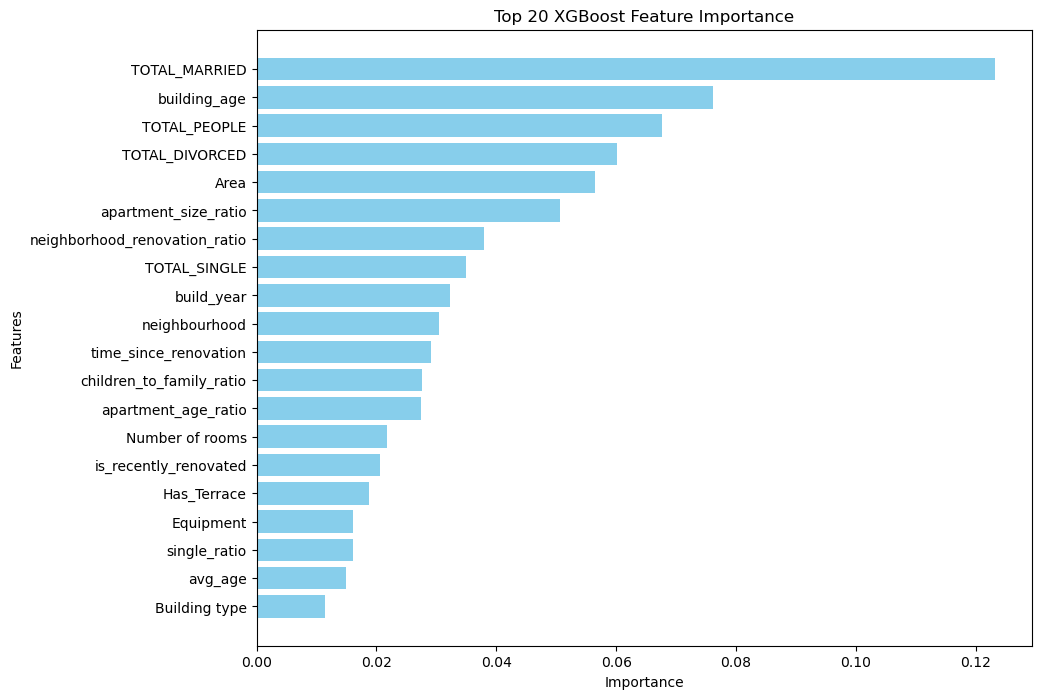


Top 20 XGBoost Feature Importance:
                          Feature  Importance
9                   TOTAL_MARRIED    0.123127
32                   building_age    0.076163
6                    TOTAL_PEOPLE    0.067693
7                  TOTAL_DIVORCED    0.060184
0                            Area    0.056524
53           apartment_size_ratio    0.050647
50  neighborhood_renovation_ratio    0.037953
10                   TOTAL_SINGLE    0.034889
11                     build_year    0.032215
12                  neighbourhood    0.030381
33          time_since_renovation    0.029083
51       children_to_family_ratio    0.027589
54            apartment_age_ratio    0.027437
1                 Number of rooms    0.021755
34          is_recently_renovated    0.020609
22                    Has_Terrace    0.018736
15                      Equipment    0.016099
41                   single_ratio    0.016097
43                        avg_age    0.014851
14                  Building type    0.01147

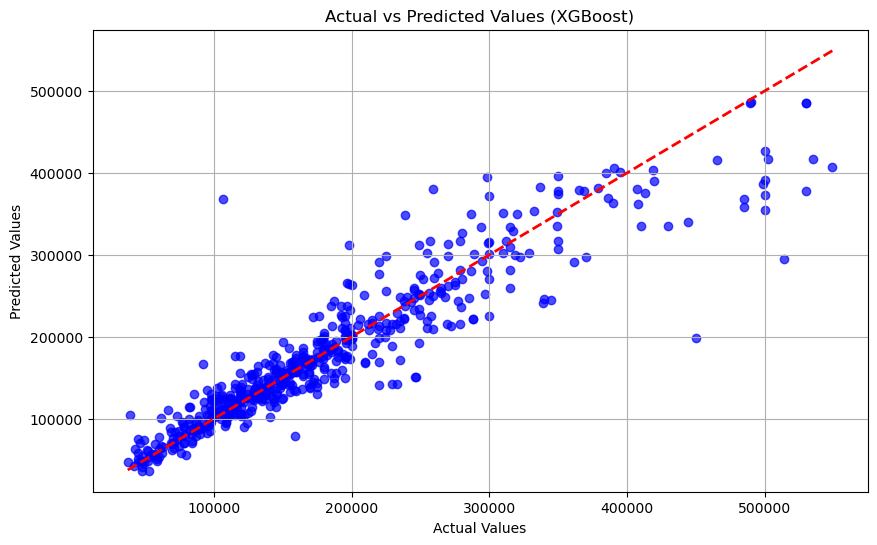

Processing LightGBM...
Training LightGBM with parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5194
[LightGBM] [Info] Number of data points in the train set: 2346, number of used features: 56
[LightGBM] [Info] Start training from score 176306.236999
LightGBM - RMSE: 35714.16, MAE: 21926.06, R^2: 0.87
[1342  127  142  302  279  178  135  186  183  121  131  473  406  567
   93  125  607  624  551  432  219   57   46   73    0    2   43   26
   36    7   21   59    8  453    0  507    0   30    0  421  223  289
  202    9  631    0    0   14  734  200  384  184  968 1202  736  205
    0    7]


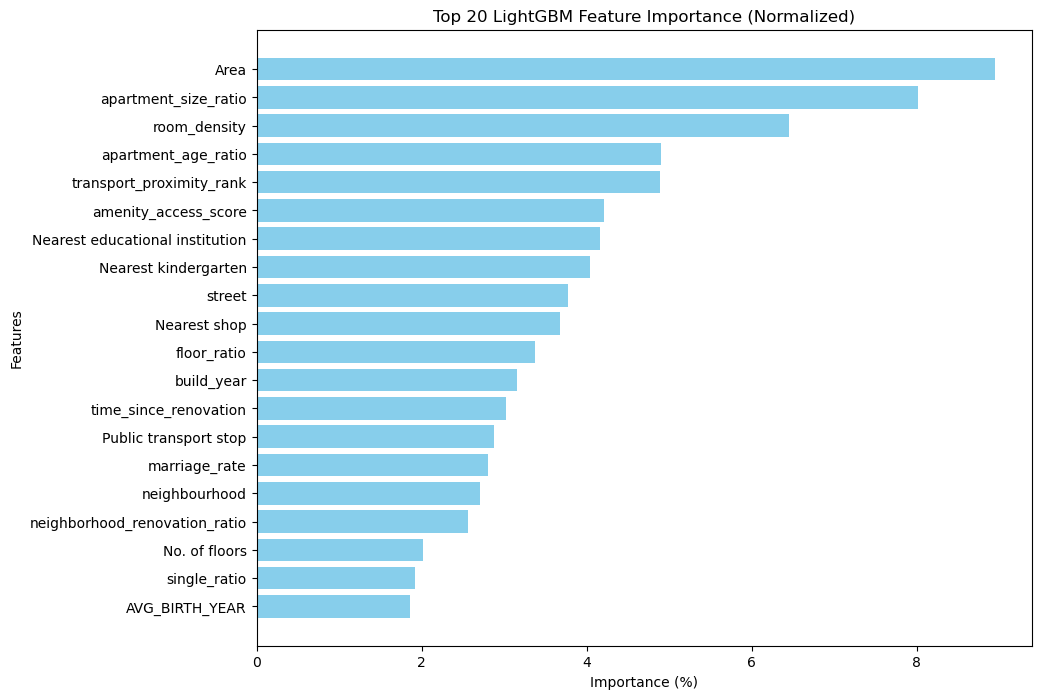


Top 20 LightGBM Feature Importance:
                            Feature  Importance
0                              Area    8.946667
53             apartment_size_ratio    8.013333
52                     room_density    6.453333
54              apartment_age_ratio    4.906667
48         transport_proximity_rank    4.893333
44             amenity_access_score    4.206667
17  Nearest educational institution    4.160000
16             Nearest kindergarten    4.046667
13                           street    3.780000
18                     Nearest shop    3.673333
35                      floor_ratio    3.380000
11                       build_year    3.153333
33            time_since_renovation    3.020000
19            Public transport stop    2.880000
39                    marriage_rate    2.806667
12                    neighbourhood    2.706667
50    neighborhood_renovation_ratio    2.560000
3                     No. of floors    2.013333
41                     single_ratio    1.926667
4  

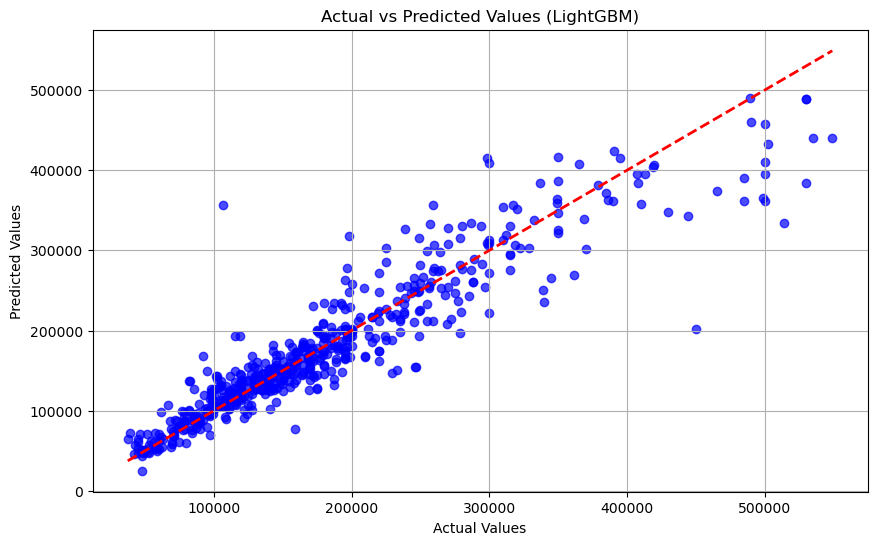

Processing GradientBoosting...
Training GradientBoosting with parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
GradientBoosting - RMSE: 38298.49, MAE: 22985.26, R^2: 0.85
[4.57921785e-01 1.06068225e-02 1.56822541e-03 9.14399940e-03
 5.60761806e-03 7.68889200e-03 2.46038048e-02 3.96617736e-02
 4.45270348e-03 3.71446425e-02 3.63402567e-03 3.13389991e-02
 3.62979268e-02 1.16140961e-02 3.04126615e-03 5.80186404e-03
 8.24018767e-03 1.72287939e-02 5.71997723e-03 5.62833856e-03
 1.64123425e-03 2.81458656e-04 2.21481096e-03 1.65447629e-03
 2.09041218e-04 3.50605476e-05 5.41233734e-04 3.67843372e-04
 4.94015371e-04 3.44609339e-05 3.72193736e-04 4.17246941e-04
 3.79856509e-02 2.92895373e-02 1.55525285e-04 4.93679376e-03
 1.58560064e-04 9.58719699e-05 1.01617019e-04 8.24803334e-03
 4.39245294e-03 1.11166595e-02 2.97975609e-03 7.06044682e-03
 1.83030512e-02 1.01874551e-05 0.00000000e+00 1.54045547e-04
 1.69265744e-02 5.70683945e-

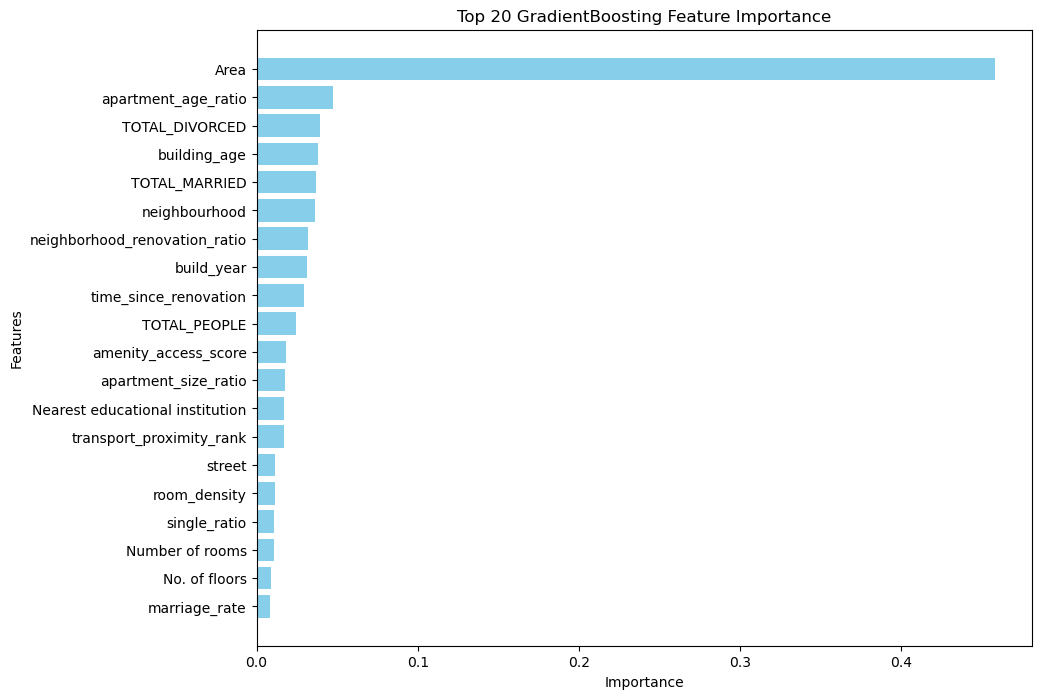


Top 20 GradientBoosting Feature Importance:
                            Feature  Importance
0                              Area    0.457922
54              apartment_age_ratio    0.047273
7                    TOTAL_DIVORCED    0.039662
32                     building_age    0.037986
9                     TOTAL_MARRIED    0.037145
12                    neighbourhood    0.036298
50    neighborhood_renovation_ratio    0.031892
11                       build_year    0.031339
33            time_since_renovation    0.029290
6                      TOTAL_PEOPLE    0.024604
44             amenity_access_score    0.018303
53             apartment_size_ratio    0.017727
17  Nearest educational institution    0.017229
48         transport_proximity_rank    0.016927
13                           street    0.011614
52                     room_density    0.011153
41                     single_ratio    0.011117
1                   Number of rooms    0.010607
3                     No. of floors    0.00

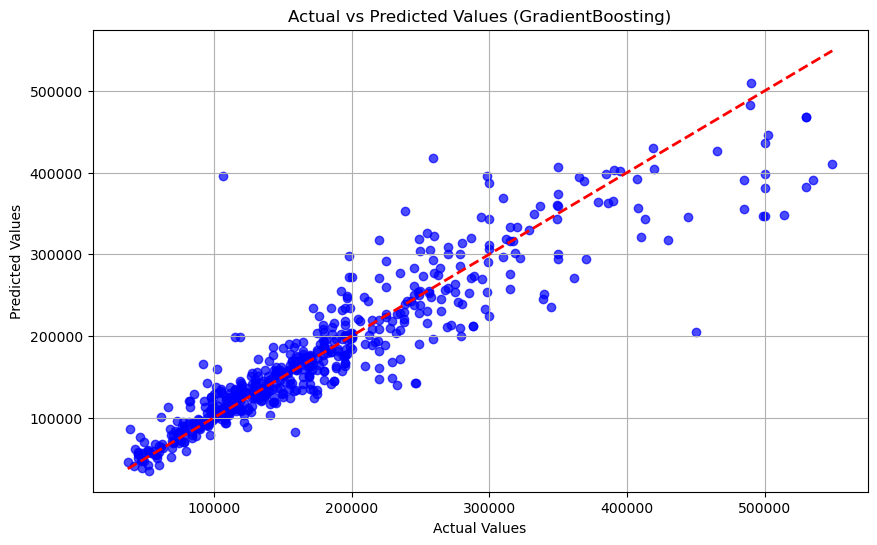

In [202]:


# Define the original column names of the input data
original_columns = X_train_group.columns.tolist()

# Identify the numeric features that were transformed
numeric_features = valid_numeric_features

# Identify the categorical and other features passed through
remaining_features = [col for col in original_columns if col not in numeric_features]

# Combine numeric and remaining features
transformed_columns = numeric_features + remaining_features

print("Transformed Column Names:")
print(transformed_columns)

# Function to extract parameters from results DataFrame
def get_best_params(results_df, group_name):
    params = results_df.loc[group_name]['Best_Params']
    if isinstance(params, str):
        params = ast.literal_eval(params)  # Convert string to dictionary if needed
    return params

# Updated plot_feature_importance function with normalization option
def plot_feature_importance(importances, feature_names, model_name, top_n=20, normalized=False):
    """
    Plots and saves the top N feature importances for a given model.

    Parameters:
    - importances: array-like, feature importance values
    - feature_names: list, names of the features
    - model_name: str, name of the model
    - top_n: int, number of top features to display
    - normalized: bool, whether to normalize the importances
    """
    if normalized:
        importances = importances / np.sum(importances) * 100  # Normalize to percentages

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Select top N features
    top_features = feature_importance_df.head(top_n)

    # Plot the top N features
    plt.figure(figsize=(10, 8))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance' + (' (%)' if normalized else ''))
    plt.ylabel('Features')
    plt.title(f'Top {top_n} {model_name} Feature Importance' + (' (Normalized)' if normalized else ''))
    plt.gca().invert_yaxis()
    plt.show()

    return top_features

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """
    Plots the actual vs predicted values for a given model.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.grid(True)
    plt.show()

# Train and evaluate models with feature importance
models = {
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor,
    "GradientBoosting": GradientBoostingRegressor
}

results_groups = {
    "XGBoost": "Group 3 - XGBoost",
    "LightGBM": "Group 3 - LightGBM",
    "GradientBoosting": "Group 3 - GradientBoosting"
}

for model_name, model_class in models.items():
    print(f"Processing {model_name}...")

    # Get best parameters for the model
    group_name = results_groups[model_name]
    best_params = get_best_params(results_tuned_df, group_name)

    # Initialize model with best parameters
    model = model_class(**best_params)
    print(f"Training {model_name} with parameters: {best_params}")

    # Train the model
    model.fit(X_train_scaled, y_train_group)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test_group, y_pred))
    mae = mean_absolute_error(y_test_group, y_pred)
    r2 = r2_score(y_test_group, y_pred)

    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R^2: {r2:.2f}")

    # Extract feature importance
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        print(importances)

        # Use transformed_columns as the feature names
        feature_names = transformed_columns

        # Handle cases where the feature names may not align with the transformed data shape
        if len(feature_names) != len(importances):
            feature_names = [f'Feature {i}' for i in range(len(importances))]

        # Normalize importances for LightGBM
        if model_name == "LightGBM":
            # Option 1: Normalize to percentages
            importances_normalized = importances / np.sum(importances) * 100
            normalization = True  # Indicates normalization was applied
        else:
            importances_normalized = importances
            normalization = False  # No normalization

        # Plot top 20 feature importance
        feature_importance_df = plot_feature_importance(
            importances_normalized,
            feature_names,
            model_name,
            top_n=20,
            normalized=normalization
        )

        print(f"\nTop 20 {model_name} Feature Importance:")
        print(feature_importance_df)

    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test_group, y_pred, model_name)
